<p> The details of the Kaggle contest in question are at https://www.kaggle.com/c/tweet-sentiment-extraction/overview. In this notebook, we attempt to pre-process input datasets to prepare them for NLP modelling. Input tweet sequences are cleaned and tokenized, and then wrapped in a BERT embedding for contextual awareness. Output text sequences are merely tokenized on an external library given the need to preserve sentence phrases. A local BERT client is used to generate the datasets. To run BERT locally, <br\><br/>
<i>
pip install bert-serving-server <br/>
pip install bert-serving-client <br/>
wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip && unzip uncased_L-12_H-768_A-12.zip
<br/>
bert-serving-start -model_dir uncased_L-12_H-768_A-12/ -num_worker=2 -max_seq_len 100
</i>
<p>
    
Since we know that the selected_text is a continuous textual segment, we attempt a different design architecture, where all possible n-grams of a text are evaluated to predict the sentiment, and the most likely n-gram is the one that most clearly encapsulates the sentiment in question.

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
from bert_serving.client import BertClient
import sklearn.metrics
import sklearn.preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pickle
import nltk.probability
from sklearn.svm import OneClassSVM
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, load_model

In [2]:
data = pd.read_csv("./data/train.csv")
testdata = pd.read_csv("./data/test.csv")
data.dropna(how="any", inplace=True)

In [3]:
def cleaner(sent):
    #Two tokens (WEBSITE, VULGAR) are created and punctuation is spaced out
    sent = " ".join(np.vectorize(lambda s:"WEBSITE" if "http" in s else s)(np.array(sent.split())))
    sent = re.sub("[!.?:;,`]", " ", sent)
    return re.sub(re.compile('(?:\*){2,}'),"VULGAR",sent).lower()
for col in ['text','selected_text']:
    data[col] = data[col].apply(lambda s: cleaner(s))
testdata['text'] = testdata['text'].apply(lambda s: cleaner(s))
data = data.loc[data.text.apply(lambda s: len(s))!=1]

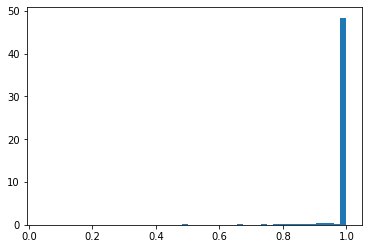

In [4]:
#NEUTRAL SELECTION RATIO
subset = data.loc[data.sentiment=="neutral", ['selected_text', 'text']].applymap(lambda s: len(s.split()))
plt.hist(subset['selected_text']/subset['text'], bins=50, density=True);

Thus, our neutral label selection algorithm will be naive, passing the entire text as the selected_text since the approach holds for over 92% of input data. We now attempt two classes of BERT Classifiers - one's a single-class classifier for each of the positive and negative selected_texts, and the other is a binary classification. On prediction, each n-gram of a tweet is run against the relevant classifier and the most likely subset is returned.

In [5]:
for sent in ["positive","negative"]:
    print("Entering Sentiment "+sent)
    #BERT-encode training set
    bc = BertClient()
    trainX = bc.encode(data.loc[data.sentiment==sent, "selected_text"].to_list())
    #Save data artifacts for modelling pipeline
    pickle.dump(trainX, open("./data/"+sent+"trainX.pkl", "wb"))

Entering Sentiment positive
Entering Sentiment negative


<h2> Binary-Class Classifier </h2>

In [5]:
postrainX = pickle.load(open("./data/positivetrainX.pkl", "rb"))
negtrainX = pickle.load(open("./data/negativetrainX.pkl", "rb"))
trainX = np.concatenate([postrainX, negtrainX])
trainY = pd.Series(np.ones(len(postrainX))).append(pd.Series(np.zeros(len(negtrainX))))

In [6]:
index = np.random.choice(len(trainX),len(trainX), replace=False)
trainX = trainX[index]
trainY = trainY.iloc[index].values

In [ ]:
#Logistic Regression
lgparams = {'C':sp.stats.uniform(loc=1e-4, scale=1e4), 'solver':['saga'], 'random_state':[1], 
            'l1_ratio':sp.stats.uniform(), 'max_iter':[1000]}
mdl = LogisticRegression(penalty="elasticnet", class_weight="balanced", random_state=1)
lgmdl = RandomizedSearchCV(mdl, lgparams, n_iter=100, cv=3, verbose=999, refit="neg_log_loss",
                           scoring=['neg_brier_score','neg_log_loss','roc_auc'], n_jobs=4, random_state=1)
lgmdl.fit(trainX, trainY)
pickle.dump(lgmdl, open('./data/logreg.pkl', 'wb'))

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


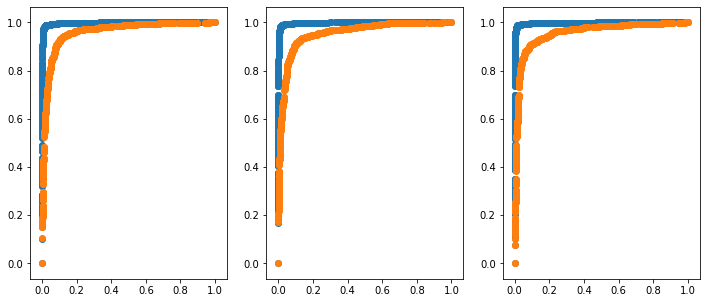

In [10]:
#Performance over the splits
lgmdl = pickle.load(open("./data/logreg.pkl", "rb"))
import copy
testsplits = np.array_split(np.arange(len(postrainX)),3)
trainsplits = [np.sort(list(set(np.arange(len(postrainX)))-set(test))) for test in testsplits]
cv = [(trainsplits[i],testsplits[i]) for i in range(3)]
plt.figure(figsize=(12,5))
for i in range(len(cv)):
    plt.subplot(1,3,i+1)
    mdl = copy.deepcopy(lgmdl.best_estimator_)
    mdl.fit(trainX[cv[i][0]], trainY[cv[i][0]])
    fpr1, tpr1, _ = sklearn.metrics.roc_curve(trainY[cv[i][0]], mdl.predict_proba(trainX[cv[i][0]])[:,1])
    fpr2, tpr2, _ = sklearn.metrics.roc_curve(trainY[cv[i][1]], mdl.predict_proba(trainX[cv[i][1]])[:,1])
    plt.scatter(fpr1, tpr1)
    plt.scatter(fpr2, tpr2)

In [50]:
#Random Forest Classifier
rfparams = {'n_estimators':[200], 'criterion':['gini', 'entropy'], 'max_depth':np.arange(10)+1, 
           'min_samples_split':[2,3,4,5,6], 'min_samples_leaf':[2,3,4,5,6], 
            'max_features':sp.stats.uniform(loc=0.5, scale=0.5), 
            'class_weight':['balanced', 'balanced_subsample']}
mdl = RandomForestClassifier(random_state=1)
rfmdl = model_selection.RandomizedSearchCV(mdl, rfparams, n_iter=100, cv=3, verbose=2, refit="neg_log_loss",
                           scoring=['brier_score_loss', 'neg_log_loss', 'roc_auc'], n_jobs=2, random_state=1)
rfmdl.fit(trainX_bert, trainY);
valid_visual(rfmdl)
pickle.dump(rfmdl, open('./data/bert-rfmdl.pkl', 'wb'))

In [51]:
#XGB Classifier

In [52]:
#ANN
def build_mdr(nunits=60, l2reg=1e-3, drp=0.1):
    model = Sequential()
    model.add(Dense(nunits, activation=activ, kernel_regularizer=tf.keras.regularizers.l2(l2reg),
                   bias_regularizer=tf.keras.regularizers.l2(l2reg)))
    model.add(Dropout(drp))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4), loss='binary_crossentropy')
    return model


In [43]:
def jaccard(str1, str2):
    a, b = set(str1.lower().split()), set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))
jaccard(grams[11], grams[16])

0.16666666666666666

In [17]:
def X(text):
    ngrams, text = [], text.split()
    for i in range(len(text)):
        for j in range(i, len(text)):
            ngrams.append(" ".join(text[i:j+1]))
    return np.array(ngrams)
def Y(ngrams, subset):
    def jaccard(str1, str2):
        a, b = set(str1.lower().split()), set(str2.lower().split())
        c = a.intersection(b)
        return float(len(c)) / (len(a) + len(b) - len(c))
    return np.vectorize(lambda s: jaccard(s, subset))(np.array(ngrams))